<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5"></font>  

sfrerich

Aim: Preprocess mouse brain single-cell data from Ximerakis 2019 Nat Neuroscience

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import os
from datetime import date
from matplotlib.pyplot import rc_context

In [2]:
sc.settings.verbosity = 3

In [3]:
main_dir='/run/user/1000/gvfs/smb-share:server=138.245.4.35,share=bd-dichgans/SF' # Linux

In [4]:
main_dir='\\\isdsynnas.srv.med.uni-muenchen.de\BD-Dichgans\SF' # Win

# Load data

Downloaded from: https://singlecell.broadinstitute.org/single_cell/study/SCP263/aging-mouse-brain 06/03/2023

In [5]:
ad = sc.read_text(main_dir+"\\P6_vasc_scRNAseq\Ximerakis2019\\expression_Aging_mouse_brain_portal_data_updated.txt").T
ad

AnnData object with n_obs × n_vars = 37069 × 14699

In [6]:
ad.obs.head()

""
Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG
Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA
Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT
Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT
Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA


In [7]:
ad.var_names

Index(['Sox17', 'Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Atp6v1h', 'Oprk1',
       'Rb1cc1', '4732440D04Rik', 'St18',
       ...
       'mt-Nd3', 'mt-Nd4l', 'mt-Nd4', 'mt-Nd5', 'mt-Nd6', 'mt-Cytb', 'Vamp7',
       'AC168977.1', 'PISD', 'DHRSX'],
      dtype='object', length=14699)

In [8]:
# add metadata
meta = pd.read_csv(main_dir+"\\P6_vasc_scRNAseq\Ximerakis2019\\meta_Aging_mouse_brain_portal_data.txt", sep="\t", skiprows=[1])
meta.head()

,NAME,cell_type,cell_type_by_age,cell_class,cell_class_by_age,all_cells_by_age,nGene,nUMI
0,Aging_mouse_brain_portal_data_6_AAACCTGAGGCCCTTG,MG,MG_2-3mo,Immune_cells,Immune_cells_2-3mo,2-3mo,1546,3546
1,Aging_mouse_brain_portal_data_6_AAACGGGAGAGACGAA,MG,MG_2-3mo,Immune_cells,Immune_cells_2-3mo,2-3mo,734,1589
2,Aging_mouse_brain_portal_data_6_AAAGTAGCAACGATCT,MG,MG_2-3mo,Immune_cells,Immune_cells_2-3mo,2-3mo,456,1129
3,Aging_mouse_brain_portal_data_6_AACCGCGCAACAACCT,MG,MG_2-3mo,Immune_cells,Immune_cells_2-3mo,2-3mo,1236,2697
4,Aging_mouse_brain_portal_data_6_AACTCCCAGTACGTAA,MG,MG_2-3mo,Immune_cells,Immune_cells_2-3mo,2-3mo,622,1115


In [9]:
assert all(ad.obs.index == meta.NAME)
ad.obs = meta
ad

AnnData object with n_obs × n_vars = 37069 × 14699
    obs: 'NAME', 'cell_type', 'cell_type_by_age', 'cell_class', 'cell_class_by_age', 'all_cells_by_age', 'nGene', 'nUMI'

In [10]:
pd.value_counts(ad.obs["cell_class"])

Oligodendrocyte_lineage    15463
Astrocyte_lineage           7097
Neuronal_lineage            5773
Immune_cells                4448
Vasculature_cells           3884
Ependymal_cells              404
Name: cell_class, dtype: int64

In [11]:
pd.value_counts(ad.obs["cell_type"])

OLG              12384
ASC               6747
NEUR_mature       5135
MG                3910
EC                2413
OPC               2187
OEG                892
PC                 735
NendC              394
MAC                377
ABC                307
EPC                274
VSMC               243
ARP                184
NSC                166
NEUR_immature      162
VLMC               105
CPC                 89
NRP                 82
Hb_VC               81
MNC                 77
DC                  55
NEUT                29
TNC                 29
HypEPC              12
Name: cell_type, dtype: int64

In [12]:
ad.obs["age"] = ad.obs["all_cells_by_age"]
pd.value_counts(ad.obs["age"])

21-22mo    21041
2-3mo      16028
Name: age, dtype: int64

In [13]:
pd.crosstab(ad.obs["cell_type"], ad.obs["cell_class"])

cell_class,Astrocyte_lineage,Ependymal_cells,Immune_cells,Neuronal_lineage,Oligodendrocyte_lineage,Vasculature_cells
cell_type,,,,,,
ABC,0,0,0,0,0,307
ARP,184,0,0,0,0,0
ASC,6747,0,0,0,0,0
CPC,0,89,0,0,0,0
DC,0,0,55,0,0,0
EC,0,0,0,0,0,2413
EPC,0,274,0,0,0,0
Hb_VC,0,0,0,0,0,81
HypEPC,0,12,0,0,0,0


In [14]:
# also see website

In [15]:
new_names = {
    'Endothelial cells': {'EC'},
    'Oligos': {'OLG'},
    'Olfactory ensheathing glia': {'OEG'},
    'Astrocytes': {'ARP','ASC'},
    'Pericytes': {'PC'},
    'SMCs': {'VSMC'},
    'Neurons': {'NRP','NEUR_immature','NEUR_mature','NendC'},
    'OPCs': {'OPC'},
    'VLMCs': {'VLMC','ABC'},
    'Microglia/Macrophages': {'MG','MAC'},
    'Neural stem cells': {'NSC'},
    'Ependymal cells': {'EPC'},
    'Hypendymal cells': {'HypEPC','TNC'},
    'Choroid plexus epithelial cells':{'CPC'},
    'Immune_Other': {'MNC','DC','NEUT'},
    'Hemoglobin-expressing vascular cells':{'Hb_VC'},
}
result = {}
for key, value in new_names.items():
    for elem in value:
        result[(elem)] = key
new_cluster_names = dict(sorted(result.items()))
print(new_cluster_names)

{'ABC': 'VLMCs', 'ARP': 'Astrocytes', 'ASC': 'Astrocytes', 'CPC': 'Choroid plexus epithelial cells', 'DC': 'Immune_Other', 'EC': 'Endothelial cells', 'EPC': 'Ependymal cells', 'Hb_VC': 'Hemoglobin-expressing vascular cells', 'HypEPC': 'Hypendymal cells', 'MAC': 'Microglia/Macrophages', 'MG': 'Microglia/Macrophages', 'MNC': 'Immune_Other', 'NEUR_immature': 'Neurons', 'NEUR_mature': 'Neurons', 'NEUT': 'Immune_Other', 'NRP': 'Neurons', 'NSC': 'Neural stem cells', 'NendC': 'Neurons', 'OEG': 'Olfactory ensheathing glia', 'OLG': 'Oligos', 'OPC': 'OPCs', 'PC': 'Pericytes', 'TNC': 'Hypendymal cells', 'VLMC': 'VLMCs', 'VSMC': 'SMCs'}


In [16]:
ad.obs['clusters'] = (
    ad.obs['cell_type']
    .map(new_cluster_names)
    .astype('category')
)

In [17]:
pd.value_counts(ad.obs["clusters"])

Oligos                                  12384
Astrocytes                               6931
Neurons                                  5773
Microglia/Macrophages                    4287
Endothelial cells                        2413
OPCs                                     2187
Olfactory ensheathing glia                892
Pericytes                                 735
VLMCs                                     412
Ependymal cells                           274
SMCs                                      243
Neural stem cells                         166
Immune_Other                              161
Choroid plexus epithelial cells            89
Hemoglobin-expressing vascular cells       81
Hypendymal cells                           41
Name: clusters, dtype: int64

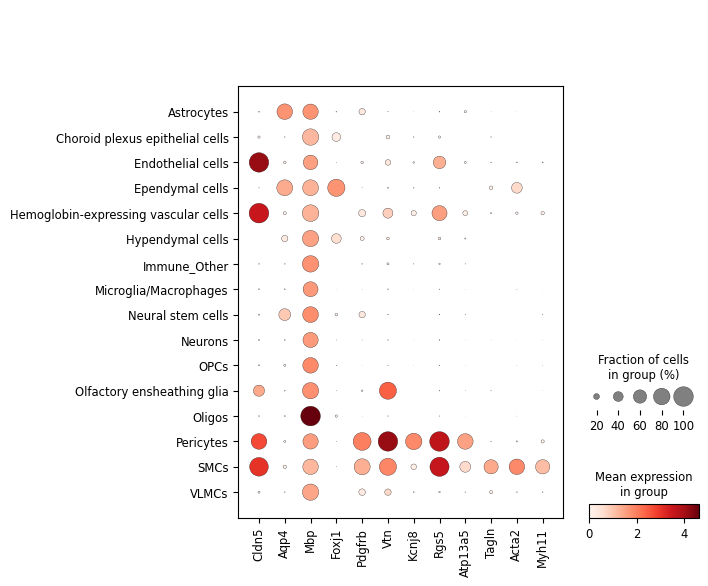

In [19]:
sc.pl.dotplot(ad, var_names=['Cldn5',"Aqp4","Mbp",'Foxj1','Pdgfrb','Vtn','Kcnj8','Rgs5','Atp13a5','Tagln','Acta2','Myh11'], groupby="clusters", swap_axes=False);

Last 4 cols are SMC markers

Check if data is normalized:

In [20]:
ad.layers

Layers with keys: 

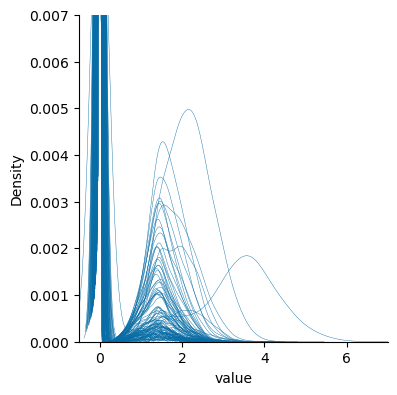

In [21]:
# show expression of 100 random genes (across all spots)
import random
import seaborn as sns
random_genes=random.sample(range(0, ad.X.shape[1]), 100)
adata_sub = ad[:,random_genes]
exp=pd.DataFrame(np.matrix(adata_sub.X))
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));
plt.show()

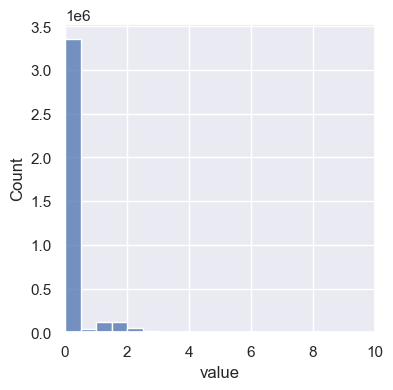

In [22]:
sns.set(rc={'figure.figsize':(4,4)})
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100)))
pl.set(xlim=(0, 10));
sns.set_style("ticks")
plt.show()

In [23]:
np.matrix(adata_sub.X)

matrix([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        ...,
        [0.       , 0.       , 2.4322278, ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ],
        [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
         0.       ]], dtype=float32)

Data seems to be normalized

In [24]:
ad.layers["normalized"] = ad.X.copy() # save normalized + log-transformed (but unscaled) counts - retrieve via adata.X = adata.layers["normalized"]

In [25]:
ad

AnnData object with n_obs × n_vars = 37069 × 14699
    obs: 'NAME', 'cell_type', 'cell_type_by_age', 'cell_class', 'cell_class_by_age', 'all_cells_by_age', 'nGene', 'nUMI', 'age', 'clusters'
    layers: 'normalized'

In [26]:
ad.layers

Layers with keys: normalized

In [27]:
sc.tl.pca(ad)
sc.pp.neighbors(ad)
sc.tl.umap(ad)
sc.tl.leiden(ad)

computing PCA
    with n_comps=50
    finished (0:00:32)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:20)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:27)
running Leiden clustering
    finished: found 32 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


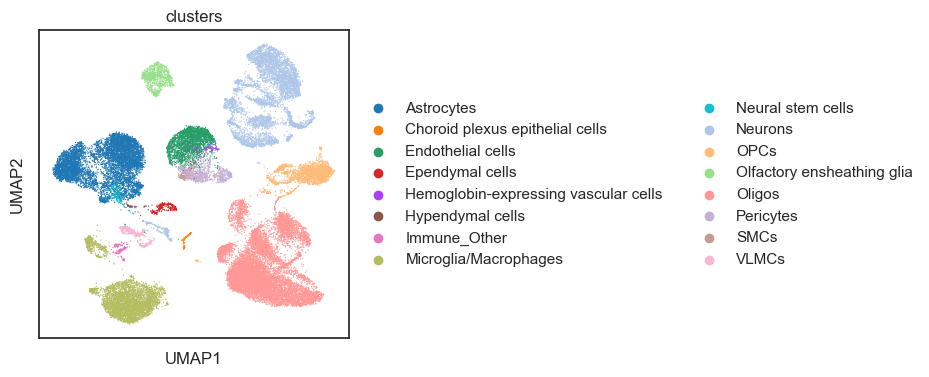

In [28]:
sc.pl.umap(ad, color=['clusters'])

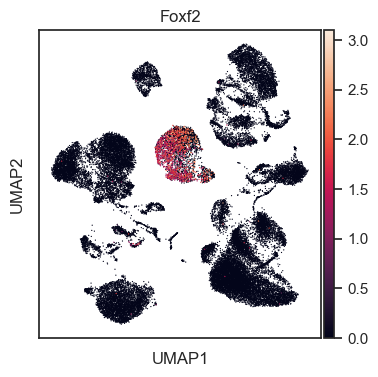

In [29]:
sc.pl.umap(ad, color=['Foxf2'])

# Focus on: Foxf2

In [30]:
adata=ad
del ad

In [ ]:
# drop uninteresting cells so that scaling is consistent
adata = adata[~adata.obs['clusters'].isin(['Hemoglobin-expressing vascular cells', 'Olfactory ensheathing glia', 'Hypendymal cells'])]

In [31]:
gene="Foxf2"

## Plot

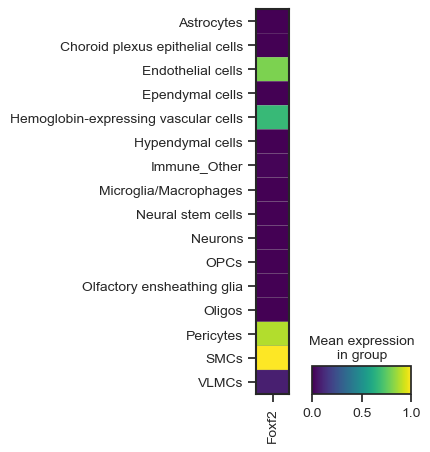

In [32]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

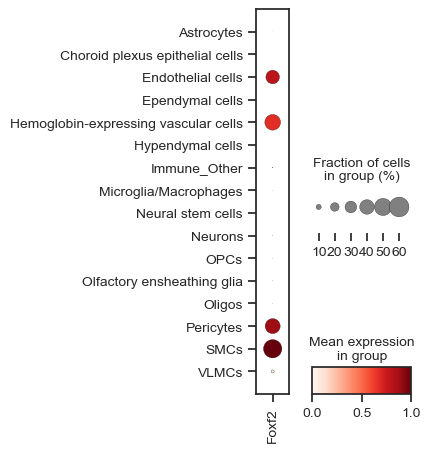

In [33]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [34]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.000600
Choroid plexus epithelial cells,0.000000
Endothelial cells,0.800882
Ependymal cells,0.000000
Hemoglobin-expressing vascular cells,0.671937
Hypendymal cells,0.000000
Immune_Other,0.008116
Microglia/Macrophages,0.001501
Neural stem cells,0.000000


In [35]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.000289
Choroid plexus epithelial cells,0.000000
Endothelial cells,0.365106
Ependymal cells,0.000000
Hemoglobin-expressing vascular cells,0.444444
Hypendymal cells,0.000000
Immune_Other,0.006211
Microglia/Macrophages,0.000933
Neural stem cells,0.000000


In [36]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Ximerakis2019"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.000600,0.000289,Foxf2,Ximerakis2019,Mouse,6931
Choroid plexus epithelial cells,0.000000,0.000000,Foxf2,Ximerakis2019,Mouse,89
Endothelial cells,0.800882,0.365106,Foxf2,Ximerakis2019,Mouse,2413
Ependymal cells,0.000000,0.000000,Foxf2,Ximerakis2019,Mouse,274
Hemoglobin-expressing vascular cells,0.671937,0.444444,Foxf2,Ximerakis2019,Mouse,81
Hypendymal cells,0.000000,0.000000,Foxf2,Ximerakis2019,Mouse,41
Immune_Other,0.008116,0.006211,Foxf2,Ximerakis2019,Mouse,161
Microglia/Macrophages,0.001501,0.000933,Foxf2,Ximerakis2019,Mouse,4287
Neural stem cells,0.000000,0.000000,Foxf2,Ximerakis2019,Mouse,166


In [37]:
# export
name='Ximerakis2019'

In [38]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Foxf2_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+name+'_normalized.csv',sep=';')

# Focus on: Other genes

## Foxo1

In [39]:
gene="Foxo1"

### Plot

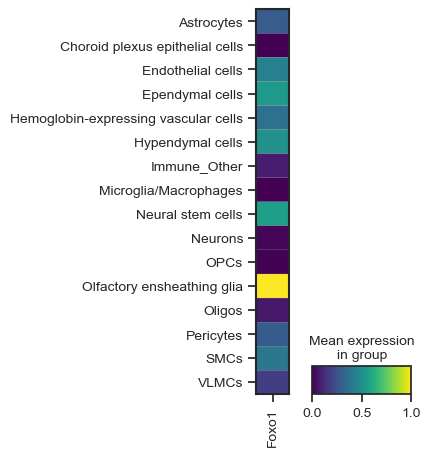

In [40]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

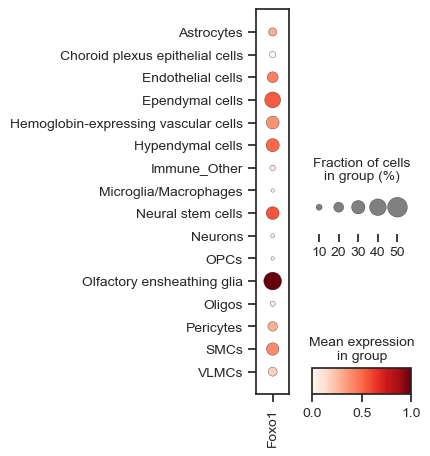

In [41]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [42]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.289164
Choroid plexus epithelial cells,0.000000
Endothelial cells,0.431416
Ependymal cells,0.537096
Hemoglobin-expressing vascular cells,0.367536
Hypendymal cells,0.503536
Immune_Other,0.076182
Microglia/Macrophages,0.001717
Neural stem cells,0.557858


In [43]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.157120
Choroid plexus epithelial cells,0.112360
Endothelial cells,0.226274
Ependymal cells,0.375912
Hemoglobin-expressing vascular cells,0.283951
Hypendymal cells,0.292683
Immune_Other,0.093168
Microglia/Macrophages,0.048286
Neural stem cells,0.283133


In [44]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Ximerakis2019"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.289164,0.157120,Foxo1,Ximerakis2019,Mouse,6931
Choroid plexus epithelial cells,0.000000,0.112360,Foxo1,Ximerakis2019,Mouse,89
Endothelial cells,0.431416,0.226274,Foxo1,Ximerakis2019,Mouse,2413
Ependymal cells,0.537096,0.375912,Foxo1,Ximerakis2019,Mouse,274
Hemoglobin-expressing vascular cells,0.367536,0.283951,Foxo1,Ximerakis2019,Mouse,81
Hypendymal cells,0.503536,0.292683,Foxo1,Ximerakis2019,Mouse,41
Immune_Other,0.076182,0.093168,Foxo1,Ximerakis2019,Mouse,161
Microglia/Macrophages,0.001717,0.048286,Foxo1,Ximerakis2019,Mouse,4287
Neural stem cells,0.557858,0.283133,Foxo1,Ximerakis2019,Mouse,166


In [45]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

## Tek = Tie2

In [46]:
gene="Tek"

### Plot

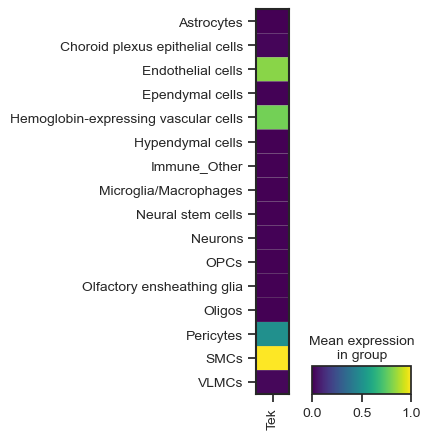

In [47]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

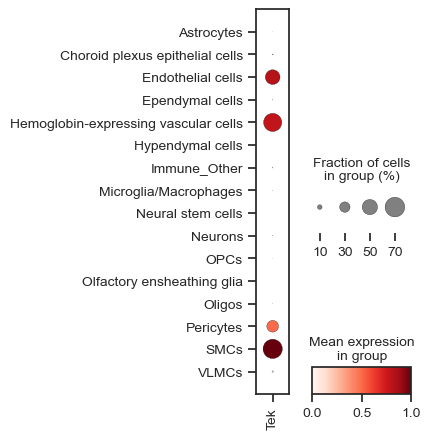

In [48]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [50]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.001154
Choroid plexus epithelial cells,0.013320
Endothelial cells,0.822978
Ependymal cells,0.007038
Hemoglobin-expressing vascular cells,0.787353
Hypendymal cells,0.000000
Immune_Other,0.003597
Microglia/Macrophages,0.002114
Neural stem cells,0.000000


In [52]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.000866
Choroid plexus epithelial cells,0.011236
Endothelial cells,0.474099
Ependymal cells,0.003650
Hemoglobin-expressing vascular cells,0.629630
Hypendymal cells,0.000000
Immune_Other,0.006211
Microglia/Macrophages,0.001866
Neural stem cells,0.000000


In [53]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Ximerakis2019"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.001154,0.000866,Tek,Ximerakis2019,Mouse,6931
Choroid plexus epithelial cells,0.013320,0.011236,Tek,Ximerakis2019,Mouse,89
Endothelial cells,0.822978,0.474099,Tek,Ximerakis2019,Mouse,2413
Ependymal cells,0.007038,0.003650,Tek,Ximerakis2019,Mouse,274
Hemoglobin-expressing vascular cells,0.787353,0.629630,Tek,Ximerakis2019,Mouse,81
Hypendymal cells,0.000000,0.000000,Tek,Ximerakis2019,Mouse,41
Immune_Other,0.003597,0.006211,Tek,Ximerakis2019,Mouse,161
Microglia/Macrophages,0.002114,0.001866,Tek,Ximerakis2019,Mouse,4287
Neural stem cells,0.000000,0.000000,Tek,Ximerakis2019,Mouse,166


In [54]:
# export
name='Ximerakis2019'

In [55]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

## Nos3 = eNOS

In [56]:
gene="Nos3"

### Plot

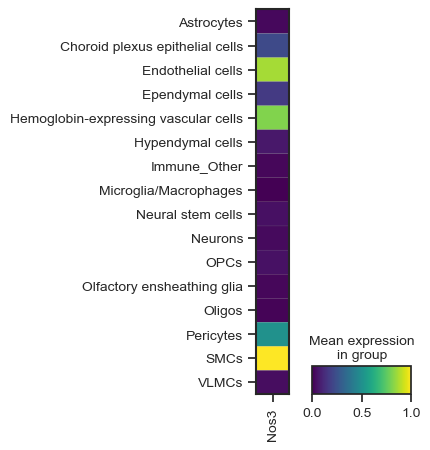

In [57]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

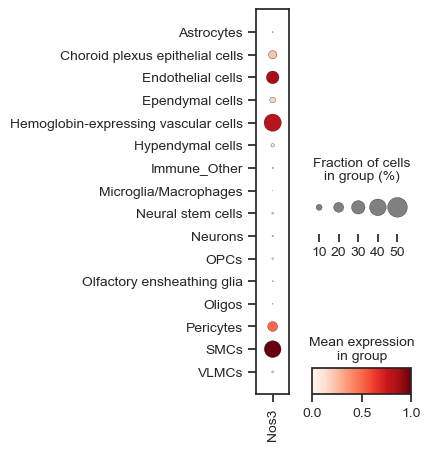

In [58]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

In [59]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

,mean_expression
clusters,
Astrocytes,0.020833
Choroid plexus epithelial cells,0.225696
Endothelial cells,0.865385
Ependymal cells,0.171545
Hemoglobin-expressing vascular cells,0.812368
Hypendymal cells,0.066195
Immune_Other,0.019121
Microglia/Macrophages,0.000000
Neural stem cells,0.040680


In [60]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

,fraction_of_cells
clusters,
Astrocytes,0.008945
Choroid plexus epithelial cells,0.157303
Endothelial cells,0.277663
Ependymal cells,0.098540
Hemoglobin-expressing vascular cells,0.419753
Hypendymal cells,0.048780
Immune_Other,0.012422
Microglia/Macrophages,0.001866
Neural stem cells,0.018072


In [61]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Ximerakis2019"
foxf2['organism'] = "Mouse"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

,mean_expression,fraction_of_cells,gene,source,organism,cell_number
clusters,,,,,,
Astrocytes,0.020833,0.008945,Nos3,Ximerakis2019,Mouse,6931
Choroid plexus epithelial cells,0.225696,0.157303,Nos3,Ximerakis2019,Mouse,89
Endothelial cells,0.865385,0.277663,Nos3,Ximerakis2019,Mouse,2413
Ependymal cells,0.171545,0.098540,Nos3,Ximerakis2019,Mouse,274
Hemoglobin-expressing vascular cells,0.812368,0.419753,Nos3,Ximerakis2019,Mouse,81
Hypendymal cells,0.066195,0.048780,Nos3,Ximerakis2019,Mouse,41
Immune_Other,0.019121,0.012422,Nos3,Ximerakis2019,Mouse,161
Microglia/Macrophages,0.000000,0.001866,Nos3,Ximerakis2019,Mouse,4287
Neural stem cells,0.040680,0.018072,Nos3,Ximerakis2019,Mouse,166


In [62]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

# Focus on: Aging

In [63]:
pd.value_counts(adata.obs["age"])

21-22mo    21041
2-3mo      16028
Name: age, dtype: int64

## Foxf2 by age group

In [64]:
gene=["Foxf2","Foxo1","Tek","Nos3"]

### All cell types

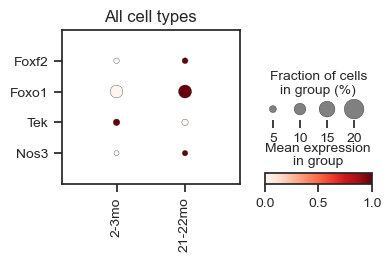

In [65]:
sc.pl.dotplot(adata, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="All cell types")

### ECs only

In [66]:
# ECs only
adata_ecs = adata[adata.obs['clusters'].isin(['Endothelial cells'])]
adata_ecs

View of AnnData object with n_obs × n_vars = 2413 × 14699
    obs: 'NAME', 'cell_type', 'cell_type_by_age', 'cell_class', 'cell_class_by_age', 'all_cells_by_age', 'nGene', 'nUMI', 'age', 'clusters', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'normalized'
    obsp: 'distances', 'connectivities'

In [67]:
pd.value_counts(adata_ecs.obs["age"])

21-22mo    1402
2-3mo      1011
Name: age, dtype: int64

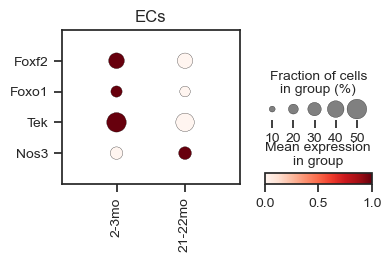

In [68]:
sc.pl.dotplot(adata_ecs, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="ECs")

### PCs only

In [69]:
adata_pcs = adata[adata.obs['clusters'].isin(['Pericytes'])]
pd.value_counts(adata_pcs.obs["age"])

21-22mo    418
2-3mo      317
Name: age, dtype: int64

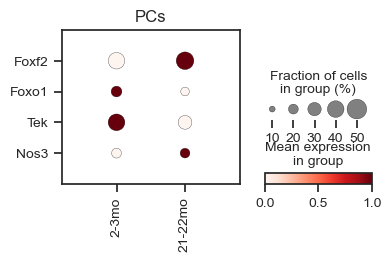

In [70]:
sc.pl.dotplot(adata_pcs, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="PCs")

### SMCs only

In [71]:
adata_pcs = adata[adata.obs['clusters'].isin(['SMCs'])]
pd.value_counts(adata_pcs.obs["age"])

21-22mo    167
2-3mo       76
Name: age, dtype: int64

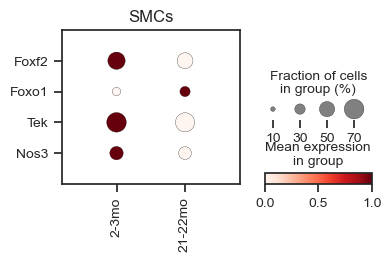

In [72]:
sc.pl.dotplot(adata_pcs, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="SMCs")

### Neurons only

In [73]:
adata_neur = adata[adata.obs['clusters'].isin(['Neurons'])]
pd.value_counts(adata_neur.obs["age"])

21-22mo    3392
2-3mo      2381
Name: age, dtype: int64

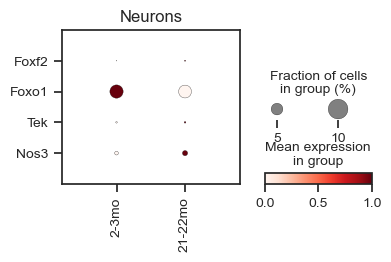

In [74]:
sc.pl.dotplot(adata_neur, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="Neurons")

### Astrocytes only

In [75]:
adata_astro = adata[adata.obs['clusters'].isin(['Astrocytes'])]
pd.value_counts(adata_astro.obs["age"])

21-22mo    3533
2-3mo      3398
Name: age, dtype: int64

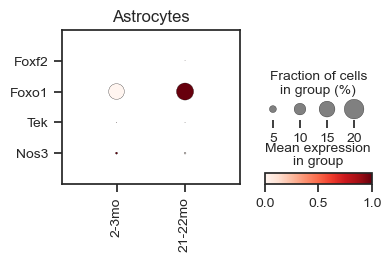

In [76]:
sc.pl.dotplot(adata_astro, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="Astrocytes")

### Oligos only

In [77]:
adata_olig = adata[adata.obs['clusters'].isin(['Oligos'])]
pd.value_counts(adata_olig.obs["age"])

21-22mo    7497
2-3mo      4887
Name: age, dtype: int64

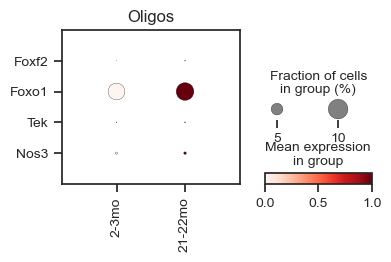

In [78]:
sc.pl.dotplot(adata_olig, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="Oligos")

### Microglia only

In [79]:
adata_mg = adata[adata.obs['clusters'].isin(['Microglia/Macrophages'])]
pd.value_counts(adata_mg.obs["age"])

21-22mo    2434
2-3mo      1853
Name: age, dtype: int64

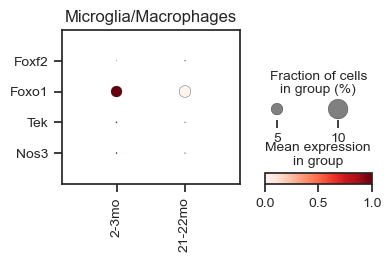

In [80]:
sc.pl.dotplot(adata_mg, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="Microglia/Macrophages")

## Correlate gene expression (Foxf2 and Foxo1)

### ECs

In [81]:
gg = ["Foxf2","Foxo1"]

In [82]:
adata

AnnData object with n_obs × n_vars = 37069 × 14699
    obs: 'NAME', 'cell_type', 'cell_type_by_age', 'cell_class', 'cell_class_by_age', 'all_cells_by_age', 'nGene', 'nUMI', 'age', 'clusters', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'normalized'
    obsp: 'distances', 'connectivities'

In [83]:
adata_ecs

View of AnnData object with n_obs × n_vars = 2413 × 14699
    obs: 'NAME', 'cell_type', 'cell_type_by_age', 'cell_class', 'cell_class_by_age', 'all_cells_by_age', 'nGene', 'nUMI', 'age', 'clusters', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'normalized'
    obsp: 'distances', 'connectivities'

In [84]:
adat = adata_ecs
subs = adat[:,gg].X
subs = pd.DataFrame(subs, columns = gg, index=adat.obs.index)
age = pd.DataFrame(adat.obs["age"])
subs = subs.join(age)
subs.head()

,Foxf2,Foxo1,age
25937,0.000000,0.000000,2-3mo
25938,0.629082,0.629082,2-3mo
25939,1.543411,1.543411,2-3mo
25940,1.611682,0.000000,2-3mo
25941,0.000000,1.844929,2-3mo


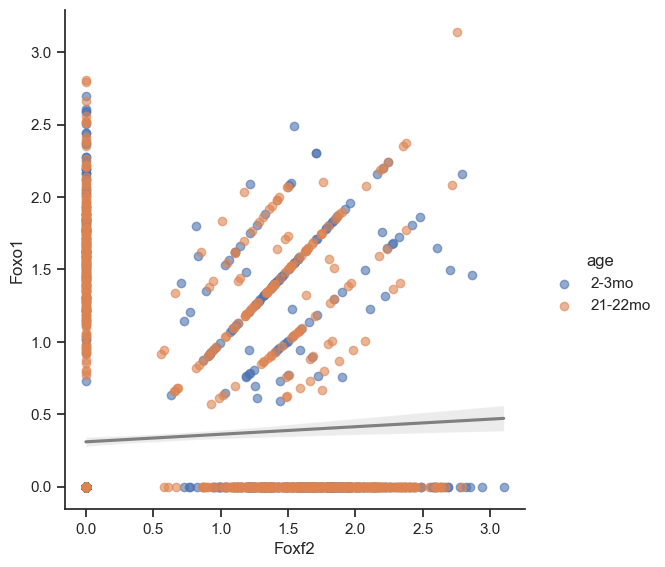

In [85]:
g = sns.lmplot(x="Foxf2", y="Foxo1", data=subs, hue="age", fit_reg=False, scatter_kws={'alpha':0.6})
sns.regplot(x="Foxf2", y="Foxo1", data=subs, scatter=False, ax=g.axes[0, 0], color="grey")
g.figure.set_size_inches(7,6)
plt.show()

In [86]:
import scipy as sp
r, p = sp.stats.pearsonr(subs['Foxf2'], subs['Foxo1'])
'Pearson R = {:.2f}, p = {:.2g}'.format(r, p)

'Pearson R = 0.07, p = 0.0013'

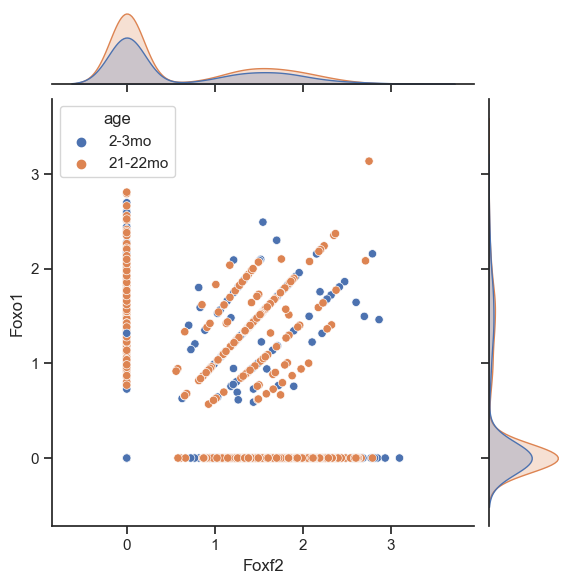

In [87]:
graph = sns.jointplot(data=subs, x="Foxf2", y="Foxo1", hue="age")
plt.show()

Exclude dropouts (cells with 0 expression of both genes)

In [88]:
coex = (adata_ecs[:,'{}'.format("Foxf2")].X > 0) | (adata_ecs[:,'{}'.format("Foxo1")].X > 0)

In [89]:
adata_ecs_above0 = adata_ecs[coex]
adata_ecs_above0

View of AnnData object with n_obs × n_vars = 1155 × 14699
    obs: 'NAME', 'cell_type', 'cell_type_by_age', 'cell_class', 'cell_class_by_age', 'all_cells_by_age', 'nGene', 'nUMI', 'age', 'clusters', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'normalized'
    obsp: 'distances', 'connectivities'

In [90]:
pd.value_counts(adata_ecs_above0.obs["age"])

21-22mo    666
2-3mo      489
Name: age, dtype: int64

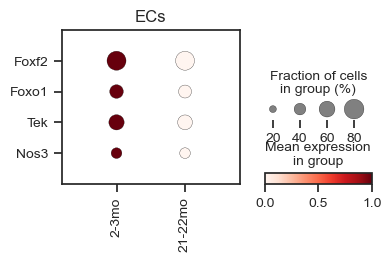

In [91]:
sc.pl.dotplot(adata_ecs_above0, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized", title="ECs")

In [92]:
adat = adata_ecs_above0
subs = adat[:,gg].X
subs = pd.DataFrame(subs, columns = gg, index=adat.obs.index)
age = pd.DataFrame(adat.obs["age"])
subs = subs.join(age)

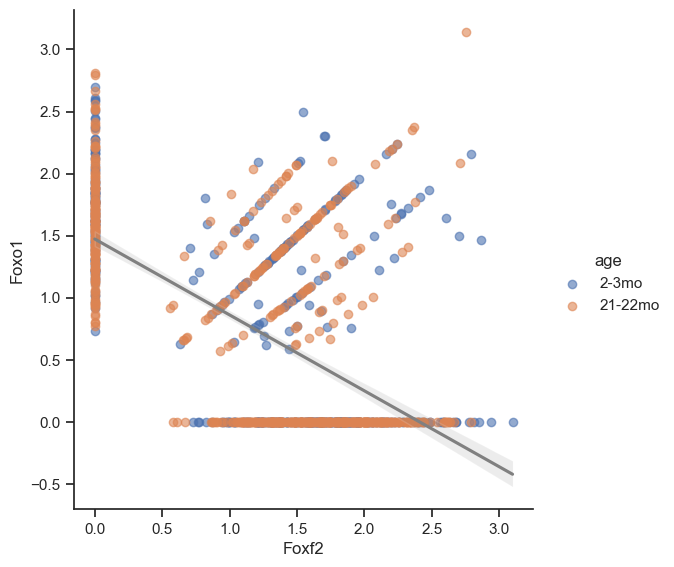

In [93]:
g = sns.lmplot(x="Foxf2", y="Foxo1", data=subs, hue="age", fit_reg=False, scatter_kws={'alpha':0.6})
sns.regplot(x="Foxf2", y="Foxo1", data=subs, scatter=False, ax=g.axes[0, 0], color="grey")
g.figure.set_size_inches(7,6)
plt.show()

In [94]:
r, p = sp.stats.pearsonr(subs['Foxf2'], subs['Foxo1'])
'Pearson R = {:.2f}, p = {:.2g}'.format(r, p)

'Pearson R = -0.60, p = 2.2e-113'

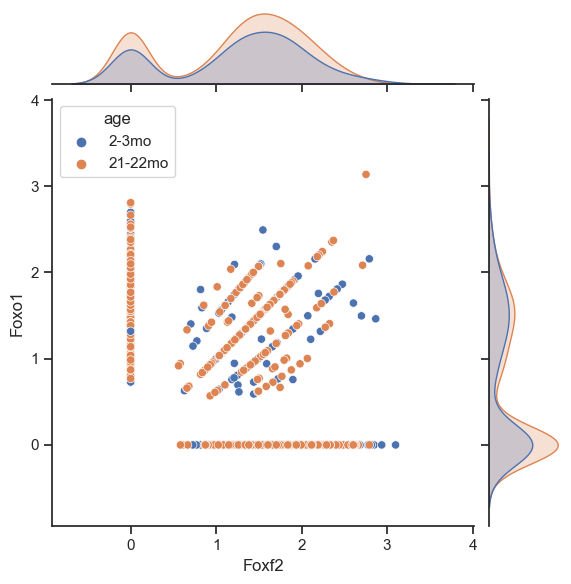

In [95]:
graph = sns.jointplot(data=subs, x="Foxf2", y="Foxo1", hue="age")
plt.show()

### All cell types

In [96]:
gg = ["Foxf2","Foxo1"]

In [97]:
adata

AnnData object with n_obs × n_vars = 37069 × 14699
    obs: 'NAME', 'cell_type', 'cell_type_by_age', 'cell_class', 'cell_class_by_age', 'all_cells_by_age', 'nGene', 'nUMI', 'age', 'clusters', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'normalized'
    obsp: 'distances', 'connectivities'

In [98]:
adat = adata
subs = adat[:,gg].X
subs = pd.DataFrame(subs, columns = gg, index=adat.obs.index)
age = pd.DataFrame(adat.obs["age"])
subs = subs.join(age)
subs.head()

,Foxf2,Foxo1,age
0,0.0,0.0,2-3mo
1,0.0,0.0,2-3mo
2,0.0,0.0,2-3mo
3,0.0,0.0,2-3mo
4,0.0,0.0,2-3mo


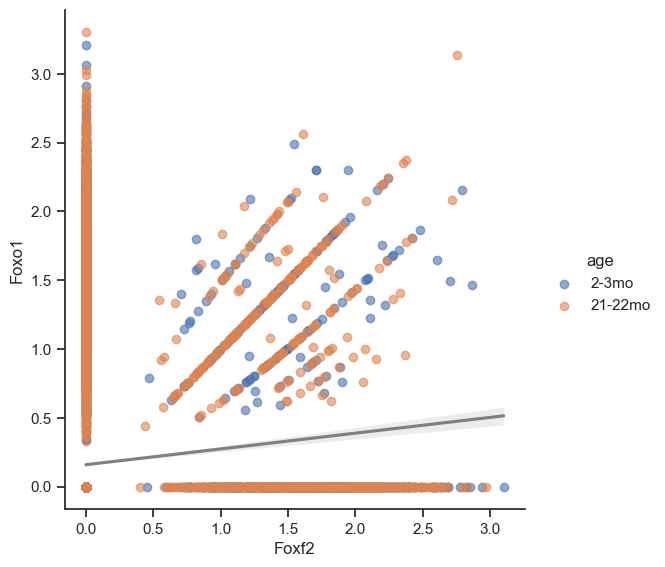

In [99]:
g = sns.lmplot(x="Foxf2", y="Foxo1", data=subs, hue="age", fit_reg=False, scatter_kws={'alpha':0.6})
sns.regplot(x="Foxf2", y="Foxo1", data=subs, scatter=False, ax=g.axes[0, 0], color="grey")
g.figure.set_size_inches(7,6)
plt.show()

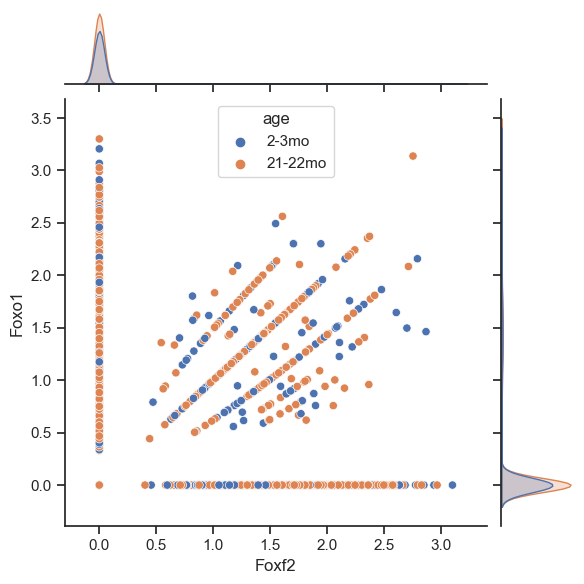

In [100]:
graph = sns.jointplot(data=subs, x="Foxf2", y="Foxo1", hue="age")
plt.show()

Exclude dropouts (cells with 0 expression of both genes)

In [101]:
coex = (adat[:,'{}'.format("Foxf2")].X > 0) | (adat[:,'{}'.format("Foxo1")].X > 0)

In [102]:
adata_above0 = adat[coex]
adata_above0

View of AnnData object with n_obs × n_vars = 5202 × 14699
    obs: 'NAME', 'cell_type', 'cell_type_by_age', 'cell_class', 'cell_class_by_age', 'all_cells_by_age', 'nGene', 'nUMI', 'age', 'clusters', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'normalized'
    obsp: 'distances', 'connectivities'

In [103]:
pd.value_counts(adata_above0.obs["age"])

21-22mo    3026
2-3mo      2176
Name: age, dtype: int64

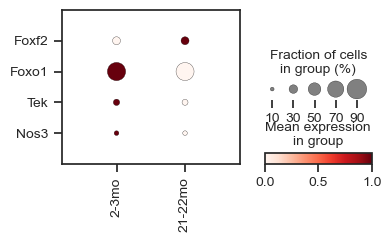

In [104]:
sc.pl.dotplot(adata_above0, gene, groupby='age', swap_axes=True, figsize=(4,2), standard_scale="var", layer="normalized")

In [105]:
adat = adata_above0
subs = adat[:,gg].X
subs = pd.DataFrame(subs, columns = gg, index=adat.obs.index)
age = pd.DataFrame(adat.obs["age"])
subs = subs.join(age)

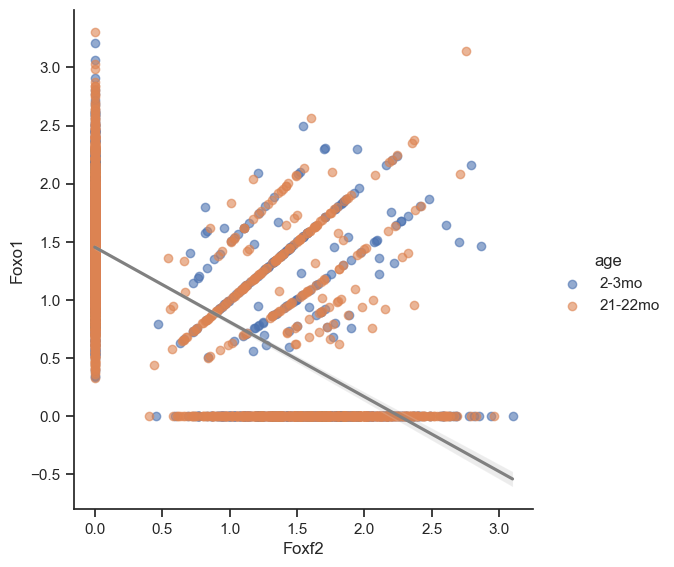

In [106]:
g = sns.lmplot(x="Foxf2", y="Foxo1", data=subs, hue="age", fit_reg=False, scatter_kws={'alpha':0.6})
sns.regplot(x="Foxf2", y="Foxo1", data=subs, scatter=False, ax=g.axes[0, 0], color="grey")
g.figure.set_size_inches(7,6)
plt.show()

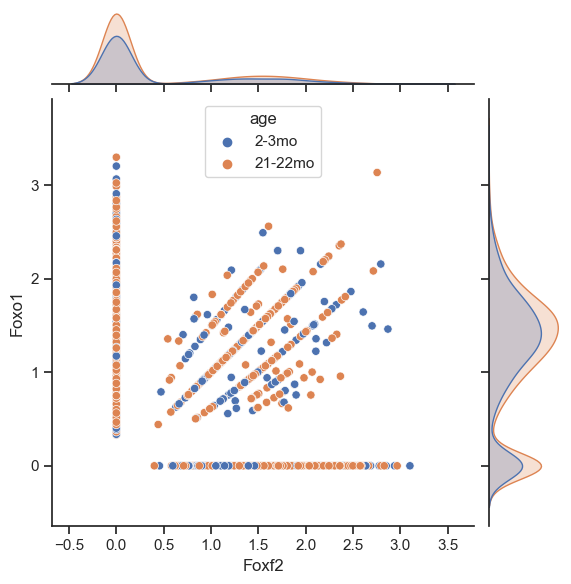

In [107]:
graph = sns.jointplot(data=subs, x="Foxf2", y="Foxo1", hue="age")
plt.show()

## Pseudobulk analysis

Because correlation on single cell level is biased by large number of dropouts

In [108]:
import decoupler as dc

In [109]:
adata

AnnData object with n_obs × n_vars = 37069 × 14699
    obs: 'NAME', 'cell_type', 'cell_type_by_age', 'cell_class', 'cell_class_by_age', 'all_cells_by_age', 'nGene', 'nUMI', 'age', 'clusters', 'leiden'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'clusters_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'normalized'
    obsp: 'distances', 'connectivities'

In [110]:
adata.obs["sample"] = adata.obs['NAME'].str.extract('_([0-9]+)_?')
pd.value_counts(adata.obs["sample"])

33    3984
34    3803
44    2928
28    2648
43    2597
27    2519
20    2279
40    2242
39    2175
21    1856
19    1851
22    1839
37    1823
7     1666
38    1489
6     1370
Name: sample, dtype: int64

In [111]:
pd.crosstab(adata.obs["sample"], adata.obs["age"]).T

sample,19,20,21,22,27,28,33,34,37,38,39,40,43,44,6,7
age,,,,,,,,,,,,,,,,
2-3mo,1851,2279,1856,1839,2519,2648,0,0,0,0,0,0,0,0,1370,1666
21-22mo,0,0,0,0,0,0,3984,3803,1823,1489,2175,2242,2597,2928,0,0


In [112]:
padata = dc.get_pseudobulk(adata, sample_col='sample', groups_col=None, layer='normalized', min_prop=0.01, min_smpls=0)

D:\Programme\Anaconda\envs\squidpy\lib\site-packages\decoupler\utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)


In [113]:
padata

View of AnnData object with n_obs × n_vars = 16 × 13311
    obs: 'all_cells_by_age', 'age', 'sample'

### Correlate gene expression (Foxf2 and Foxo1)

#### All cell types

In [114]:
gg = ["Foxf2","Foxo1"]

In [115]:
padata

View of AnnData object with n_obs × n_vars = 16 × 13311
    obs: 'all_cells_by_age', 'age', 'sample'

In [116]:
adat = padata
subs = adat[:,gg].X
subs = pd.DataFrame(subs, columns = gg, index=adat.obs.index)
age = pd.DataFrame(adat.obs["age"])
subs = subs.join(age)
subs.head()

,Foxf2,Foxo1,age
19,116.895699,319.274170,2-3mo
20,137.592239,353.048340,2-3mo
21,94.136703,280.071716,2-3mo
22,87.729050,303.521088,2-3mo
27,141.274338,392.612549,2-3mo


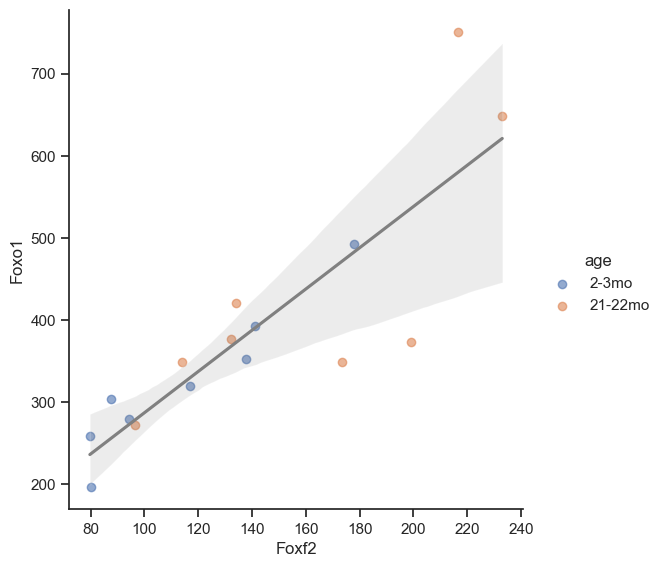

In [117]:
g = sns.lmplot(x="Foxf2", y="Foxo1", data=subs, hue="age", fit_reg=False, scatter_kws={'alpha':0.6})
sns.regplot(x="Foxf2", y="Foxo1", data=subs, scatter=False, ax=g.axes[0, 0], color="grey")
g.figure.set_size_inches(7,6)
plt.show()

In [118]:
import scipy as sp
r, p = sp.stats.pearsonr(subs['Foxf2'], subs['Foxo1'])
'Pearson R = {:.2f}, p = {:.2g}'.format(r, p)

'Pearson R = 0.86, p = 2e-05'

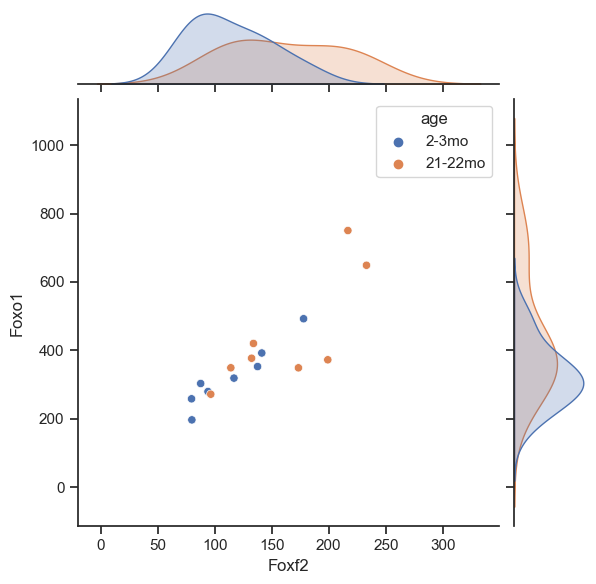

In [119]:
graph = sns.jointplot(data=subs, x="Foxf2", y="Foxo1", hue="age")
plt.show()

#### ECs

In [120]:
padata = dc.get_pseudobulk(adata, sample_col='sample', groups_col='clusters', layer='normalized', min_prop=0.2, min_smpls=3)

D:\Programme\Anaconda\envs\squidpy\lib\site-packages\decoupler\utils_anndata.py:203: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  psbulk = AnnData(psbulk, obs=new_obs, var=new_var)


In [121]:
padata

View of AnnData object with n_obs × n_vars = 177 × 9116
    obs: 'cell_class', 'cell_class_by_age', 'all_cells_by_age', 'age', 'clusters', 'sample'

In [122]:
# ECs only
padata_ecs = padata[padata.obs['clusters'].isin(['Endothelial cells'])]
padata_ecs

View of AnnData object with n_obs × n_vars = 16 × 9116
    obs: 'cell_class', 'cell_class_by_age', 'all_cells_by_age', 'age', 'clusters', 'sample'

In [123]:
gg = ["Foxf2","Foxo1"]

In [124]:
adat = padata_ecs
subs = adat[:,gg].X
subs = pd.DataFrame(subs, columns = gg, index=adat.obs.index)
age = pd.DataFrame(adat.obs["age"])
subs = subs.join(age)
subs.head()

,Foxf2,Foxo1,age
19_Endothelial cells,73.825768,51.537140,2-3mo
20_Endothelial cells,88.930351,45.764889,2-3mo
21_Endothelial cells,61.846519,43.998405,2-3mo
22_Endothelial cells,60.701096,30.795637,2-3mo
27_Endothelial cells,94.829109,66.395706,2-3mo


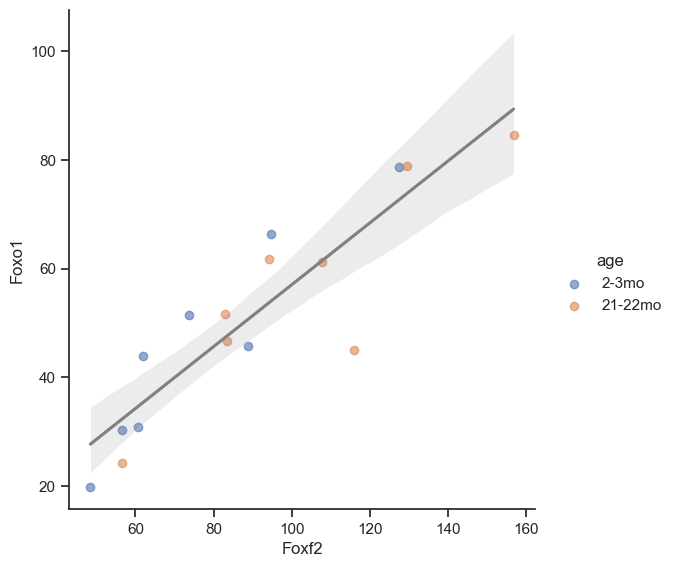

In [125]:
g = sns.lmplot(x="Foxf2", y="Foxo1", data=subs, hue="age", fit_reg=False, scatter_kws={'alpha':0.6})
sns.regplot(x="Foxf2", y="Foxo1", data=subs, scatter=False, ax=g.axes[0, 0], color="grey")
g.figure.set_size_inches(7,6)
plt.show()

In [126]:
import scipy as sp
r, p = sp.stats.pearsonr(subs['Foxf2'], subs['Foxo1'])
'Pearson R = {:.2f}, p = {:.2g}'.format(r, p)

'Pearson R = 0.90, p = 2.1e-06'

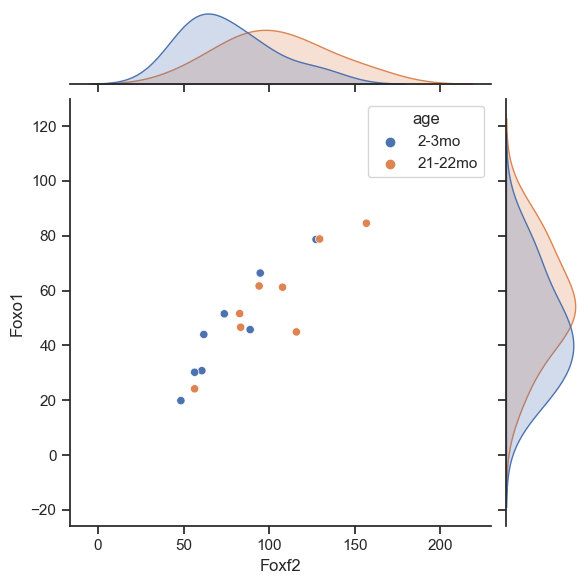

In [127]:
graph = sns.jointplot(data=subs, x="Foxf2", y="Foxo1", hue="age")
plt.show()

# Session Info

In [128]:
sc.logging.print_versions()

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
asciitree                   NA
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cffi                        1.15.1
cloudpickle                 2.0.0
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dask                        2022.05.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
decoupler                   1.1.0
defusedxml                  0.7.1
entrypoints                 0.4
executing                   0.8.3
fasteners                   0.17.3
fsspec                      2022.3.0
h5py                        3.6.0
hypergeom_ufunc             NA
igraph                      0.9.10
ipykernel                   6.15.2
ipython_genutils            0.2.0
ipywidgets                  7.7.0
jedi    